<a href="https://colab.research.google.com/github/shama-llama/crop-mapping/blob/main/src/cmap_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Crop Mapping with Deep Learning

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [19]:
import io
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split

import tensorflow as tf

### Parameter Configuration

In [20]:
# Dataset parameters
hdf5_path = "/content/drive/MyDrive/projects/crop-mapping-with-deep-learning/crop-mapping/dataset/dataset_ca_17.hdf5"
image_size = (65,65)  # Target size
image_height, image_width = image_size
# Use only the RGB sensor
sensor = "RGB"
crop_mapping = {
    "BARLEY": 0,
    "CANOLA": 1,
    "CORN": 2,
    "MIXEDWOOD": 3,
    "OAT": 4,
    "ORCHARD": 5,
    "PASTURE": 6,
    "POTATO": 7,
    "SOYBEAN": 8,
    "SPRING_WHEAT": 9,
}

# Split parameters
test_size = 0.3
val_size = 0.15

# Augmentation parameters
augmentation_params = {
    'hflip_prob': 0.5,
    'vflip_prob': 0.3,
    'rotate_prob': 0.4,
    'rotate_range': (-25, 25),
    'brightness_range': (0.8, 1.2)
}

# Training parameters
batch_size = 32
num_classes = 10
input_shape = (image_height, image_width, 3)
epochs = 30
patience = 5

# Set random seed
random.seed(42)
np.random.seed(42)

### Load and Verify Dataset

In [21]:
def decode_image(uint8_array):
    if uint8_array.size == 0:
        return None
    image_bytes = uint8_array.tobytes()
    try:
        image = Image.open(io.BytesIO(image_bytes))
        # Ensure image is in RGB format
        image = image.convert("RGB")
        return image
    except Exception as e:
        print("Error decoding RGB image:", e)
        return None

In [22]:
def load_rgb_records(hdf5_path):
    records = []
    with h5py.File(hdf5_path, "r") as hf:
        num_records = hf["POINT"].shape[0]
        for idx in range(num_records):
            record = {
                "DATE": hf["DATE"][idx],
                "POINT": hf["POINT"][idx],
                "REGION": hf["REGION"][idx],
                "LABEL": hf["LABEL"][idx],
            }
            rgb_data = hf[sensor][idx]
            record[sensor] = decode_image(rgb_data).resize(image_size)
            records.append(record)
    return records

records = load_rgb_records(hdf5_path)
print("Loaded", len(records), "records.")

Loaded 14111 records.


### Inspect Sample Record

In [23]:
selected_record = random.choice(records)
print("Selected Record Details:")
print("LABEL:", selected_record['LABEL'])

if selected_record[sensor]:
    print(f"{sensor} image size:", selected_record[sensor].size)
else:
    print(f"{sensor} image missing.")

Selected Record Details:
LABEL: 8
RGB image size: (65, 65)


### Prepare Data Arrays

In [24]:
# Change image into numpy array
def preprocess_image(image):
    return np.array(image)

In [25]:
X = []
y = []
for record in records:
    img = record[sensor]
    if img is not None:
        X.append(preprocess_image(img))
        y.append(record["LABEL"])
X = np.array(X)
y = np.array(y)
print("Total valid records:", len(X))

Total valid records: 14111


### Train/Validation/Test Split

In [26]:
# First, split 30% of the data for combined validation and test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Then, split the temporary set equally to get 15% validation and 15% test each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Validation:",
      X_val.shape, "Test:", X_test.shape)

# Check class distribution in splits
def analyze_distribution(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{set_name} class distribution:")
    for cls, count in zip(unique, counts):
        cls_name = list(crop_mapping.keys())[cls]
        print(f"{cls_name}: {count} samples ({count/len(y):.2%})")

analyze_distribution(y_train, "Training")
analyze_distribution(y_val, "Validation")

Train: (9877, 65, 65, 3) Validation: (2117, 65, 65, 3) Test: (2117, 65, 65, 3)

Training class distribution:
BARLEY: 606 samples (6.14%)
CANOLA: 1204 samples (12.19%)
CORN: 1025 samples (10.38%)
MIXEDWOOD: 685 samples (6.94%)
OAT: 405 samples (4.10%)
ORCHARD: 1108 samples (11.22%)
PASTURE: 1431 samples (14.49%)
POTATO: 589 samples (5.96%)
SOYBEAN: 1533 samples (15.52%)
SPRING_WHEAT: 1291 samples (13.07%)

Validation class distribution:
BARLEY: 130 samples (6.14%)
CANOLA: 258 samples (12.19%)
CORN: 220 samples (10.39%)
MIXEDWOOD: 147 samples (6.94%)
OAT: 86 samples (4.06%)
ORCHARD: 237 samples (11.20%)
PASTURE: 307 samples (14.50%)
POTATO: 126 samples (5.95%)
SOYBEAN: 329 samples (15.54%)
SPRING_WHEAT: 277 samples (13.08%)


###  TensorFlow Dataset Pipeline

In [56]:
def create_dataset(X, y, augment=False):
    # Convert numpy arrays to TensorFlow dataset
    y = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    # Standard preprocessing (applied to all datasets)
    def _base_preprocess(image, label):
        # Ensure image is float32 in [0,1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image, label

    # Augmentation pipeline (only for training)
    def _augment(image, label):
        # Random horizontal flip
        image = tf.image.random_flip_left_right(image)

        # Random brightness
        image = tf.image.random_brightness(image, max_delta=0.2)

        return image, label

    # Apply preprocessing
    dataset = dataset.map(_base_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentations if needed
    if augment:
        dataset = dataset.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)

    # Optimize dataset performance
    return dataset.shuffle(1000, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(X_train, y_train, augment=True)
val_dataset = create_dataset(X_val, y_val, augment=False)
test_dataset = create_dataset(X_test, y_test, augment=False)

### Model Definition

In [57]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation

# Create the model
model = models.Sequential()

model.add(Conv2D(32,(3,3),input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

# Compile the model
model.compile(Adam (lr=.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 508,618 (1.94 MB)

 Trainable params: 508,618 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

### Class Weight Calculation

In [58]:
from sklearn.utils import class_weight

# Verify and calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i:w for i,w in enumerate(class_weights)}

print("Final Class Weights:")
for cls_idx, weight in class_weights.items():
    cls_name = list(crop_mapping.keys())[cls_idx]
    print(f"{cls_name}: {weight:.2f}")

Final Class Weights:
BARLEY: 1.63
CANOLA: 0.82
CORN: 0.96
MIXEDWOOD: 1.44
OAT: 2.44
ORCHARD: 0.89
PASTURE: 0.69
POTATO: 1.68
SOYBEAN: 0.64
SPRING_WHEAT: 0.77


### Model Training

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
callbacks = [early_stop]

# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - accuracy: 0.1812 - loss: 2.1697 - val_accuracy: 0.3155 - val_loss: 1.8416
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 88s 286ms/step - accuracy: 0.3073 - loss: 1.8351 - val_accuracy: 0.3349 - val_loss: 1.8378
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 88s 285ms/step - accuracy: 0.3566 - loss: 1.7347 - val_accuracy: 0.3883 - val_loss: 1.6430
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 89s 287ms/step - accuracy: 0.3740 - loss: 1.6689 - val_accuracy: 0.4053 - val_loss: 1.6281
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 137s 271ms/step - accuracy: 0.3950 - loss: 1.6249 - val_accuracy: 0.4105 - val_loss: 1.5944
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 83s 269ms/step - accuracy: 0.4103 - loss: 1.5890 - val_accuracy: 0.4209 - val_loss: 1.6038
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 301ms/step - accuracy: 0.4103 - loss: 1.5871 - val_accuracy: 0.4209 - val_loss: 1.5830
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 148s 319ms/step - accuracy: 0.4156 - loss:

### Model Evaluation

In [60]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4395 - loss: 1.4960
Test Loss: 1.5037227869033813
Test Accuracy: 0.4397732615470886


### Plot Training Curves

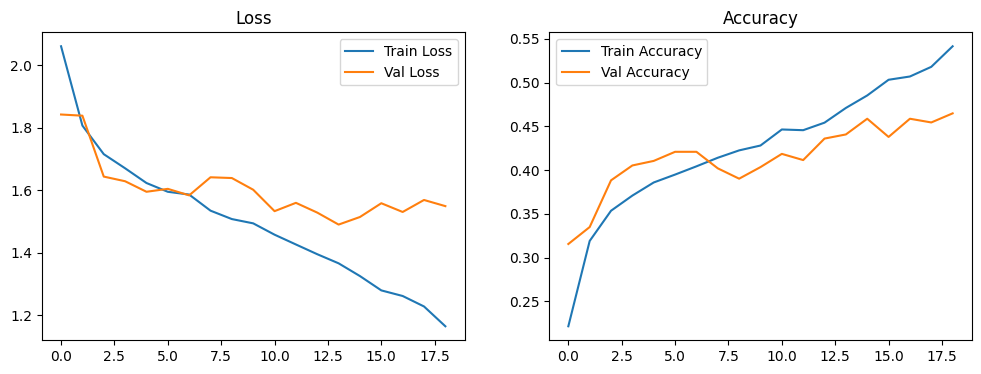

In [61]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()